## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
#importing some useful packages
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

IMAGE_SHAPE = (720,1280,3)

CAL_IMAGES_DIR = "camera_cal/"
TEST_IMAGES_DIR = "test_images/"

CAL_NX = 9 # the number of inside corners in x
CAL_NY = 6 # the number of inside corners in y

def calibrate_camera(imgdir, nx, ny):
    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for filename in os.listdir(imgdir):
        # Read in an image
        img = cv2.imread(imgdir + filename)
    
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    height, width, _ = IMAGE_SHAPE
    
    # Use cv2.calibrateCamera() and cv2.undistort()
    print("Calibrating camera...")
    error, mtx, coefs, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, (width, height) , None, None)
    print("Reprojection error: {:6f}".format(error))   
    
    return mtx, coefs


mtx, dist = calibrate_camera(CAL_IMAGES_DIR, CAL_NX, CAL_NY)

Calibrating camera...
Reprojection error: 1.186897


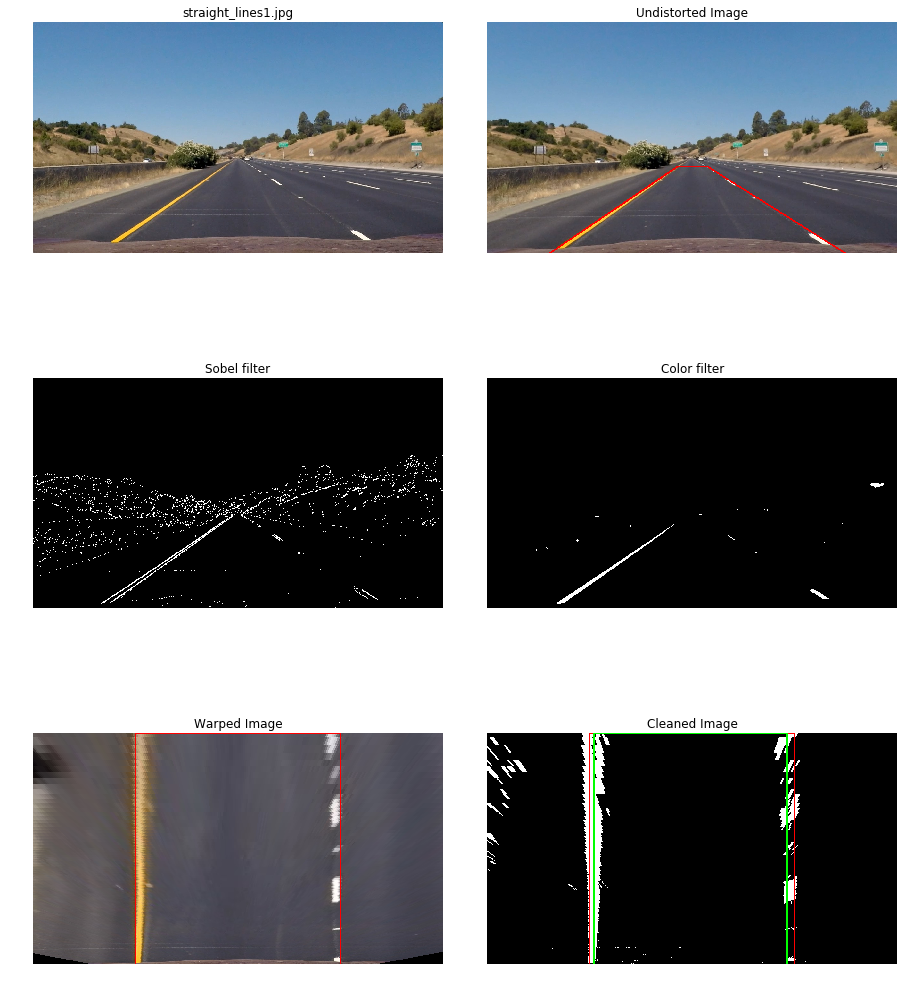

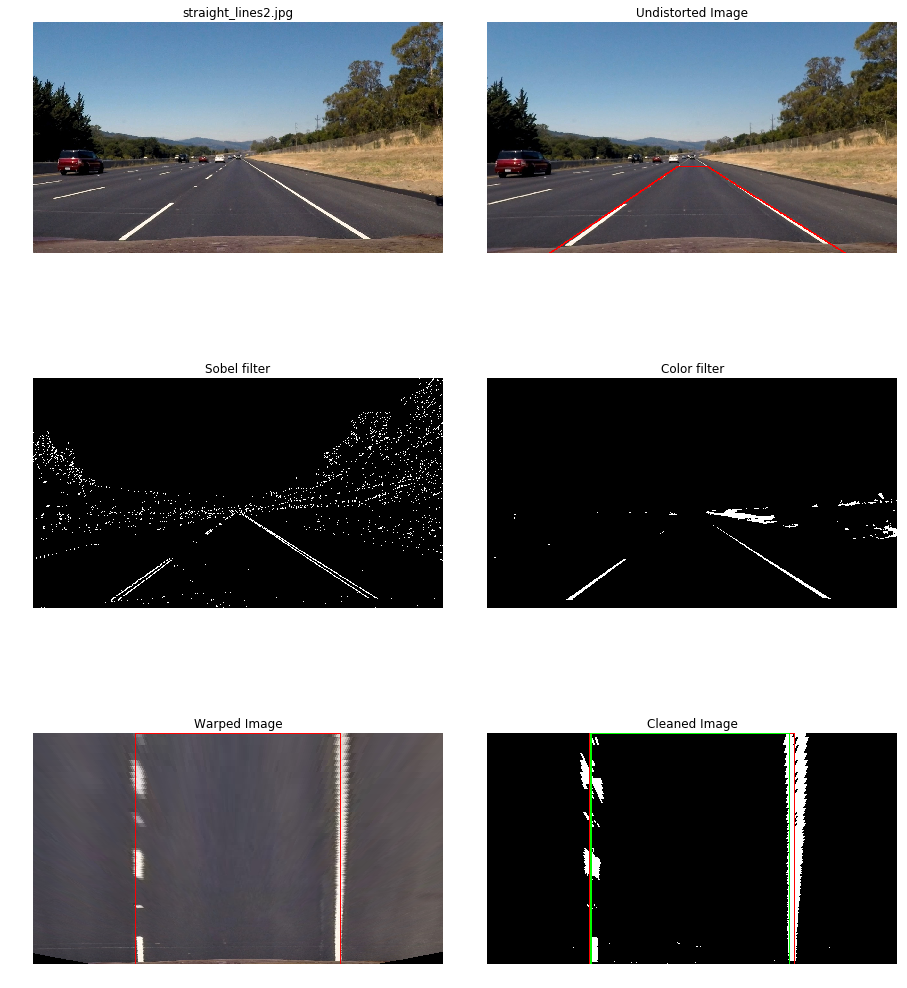

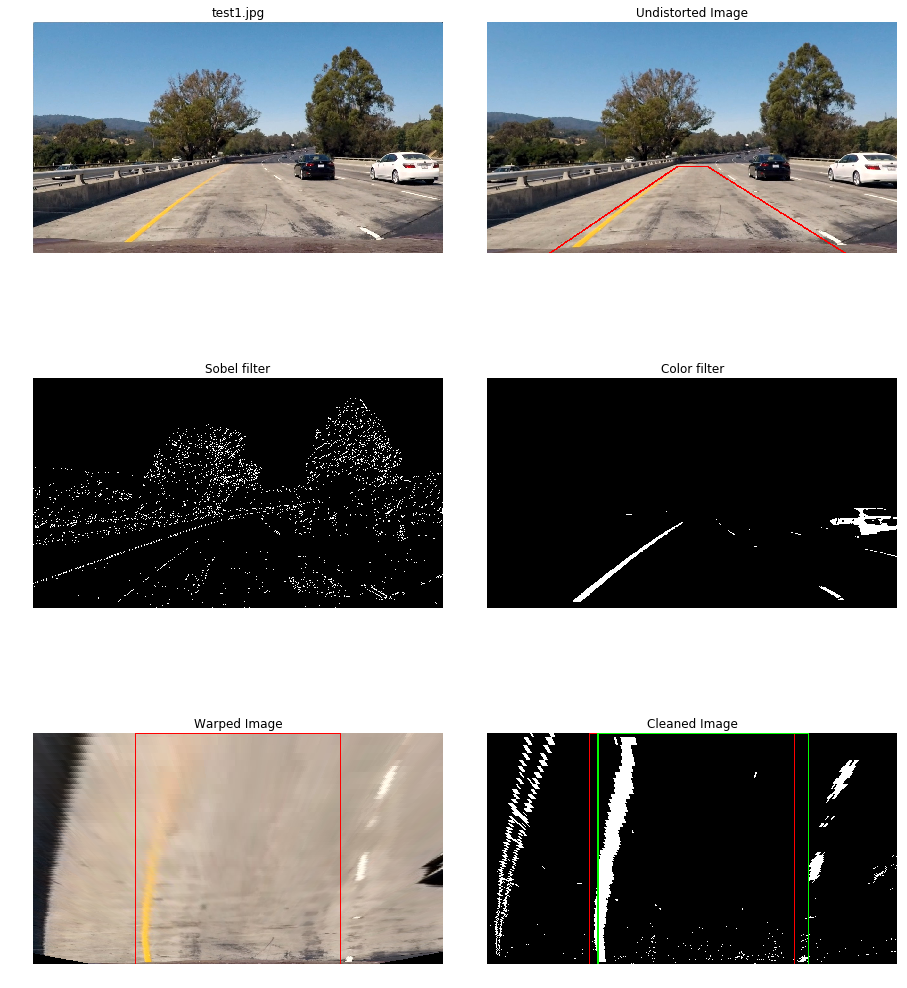

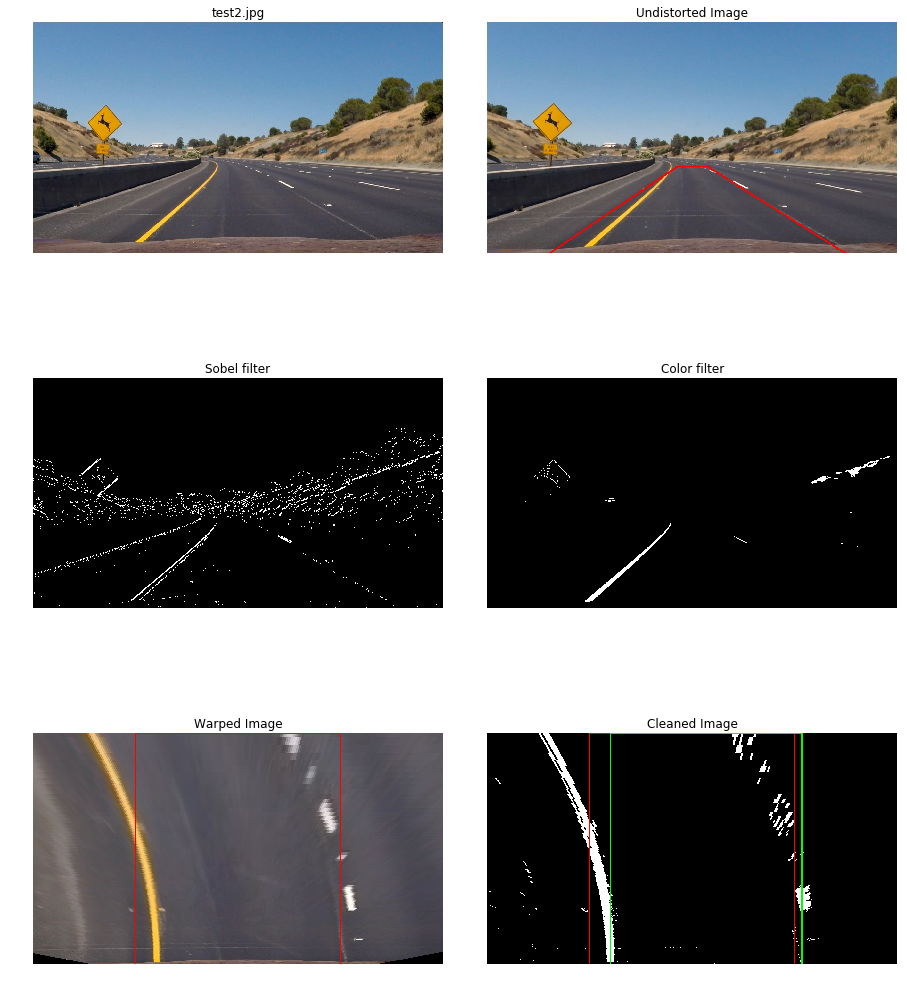

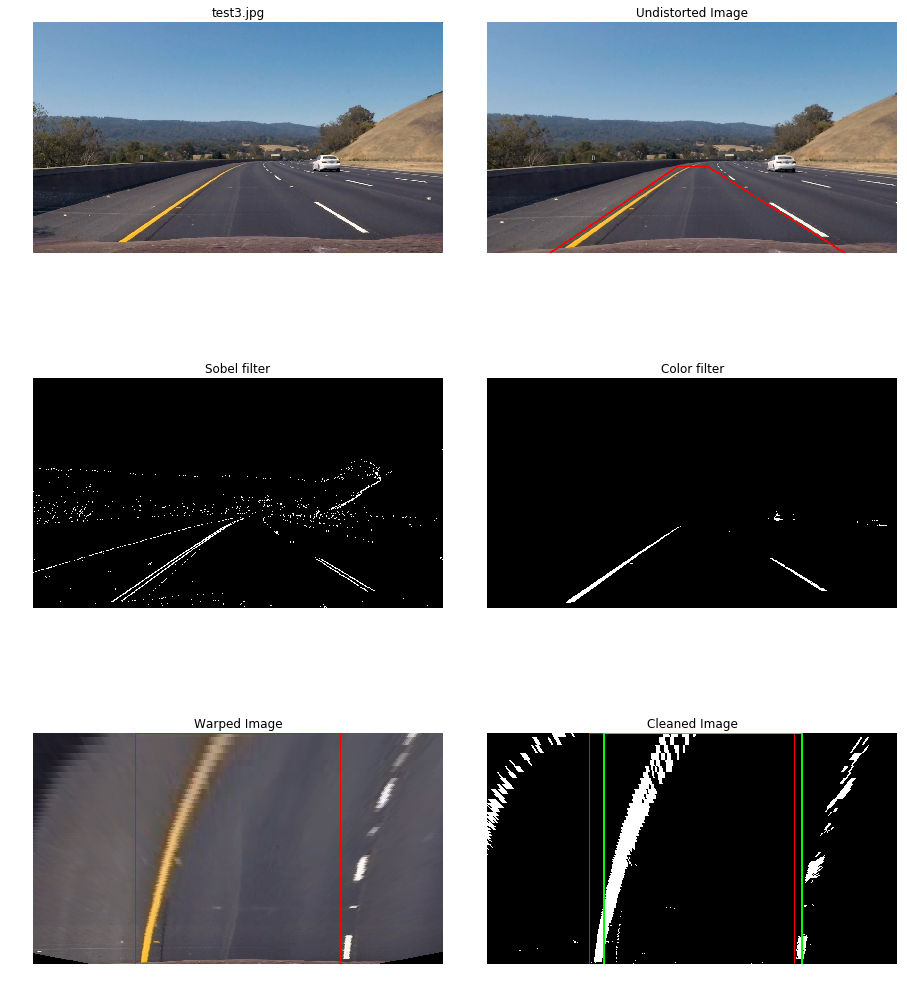

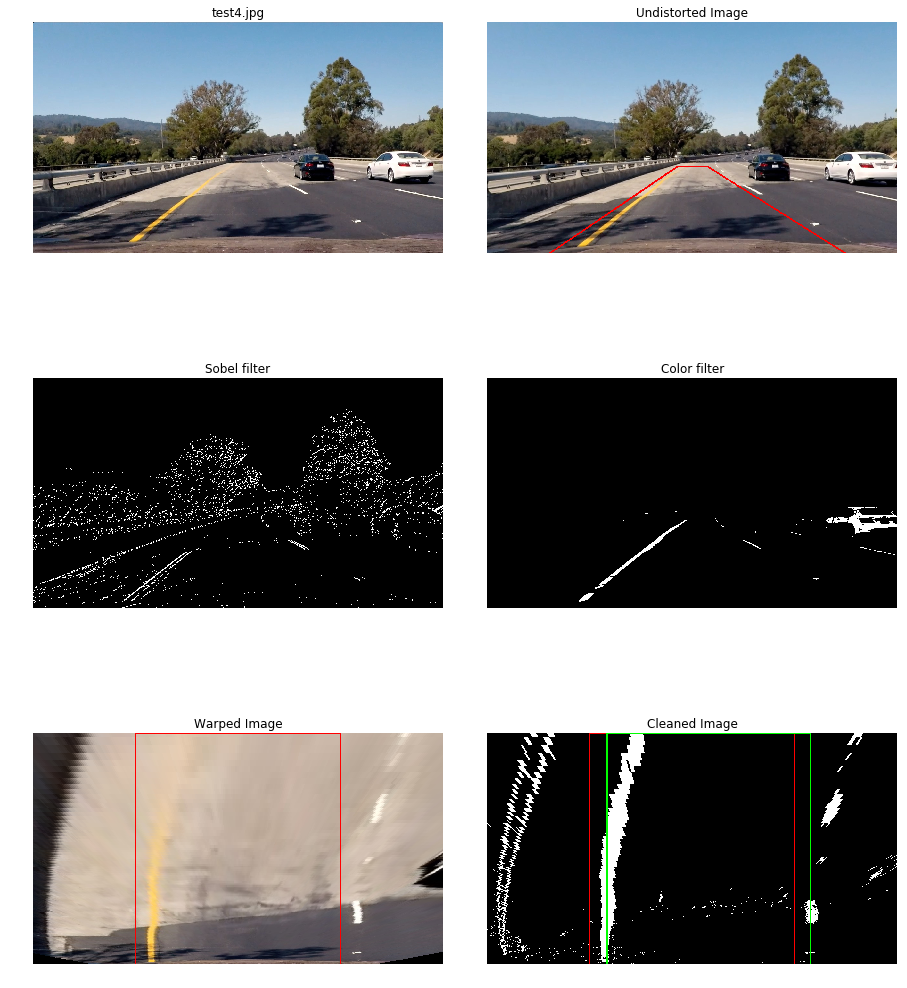

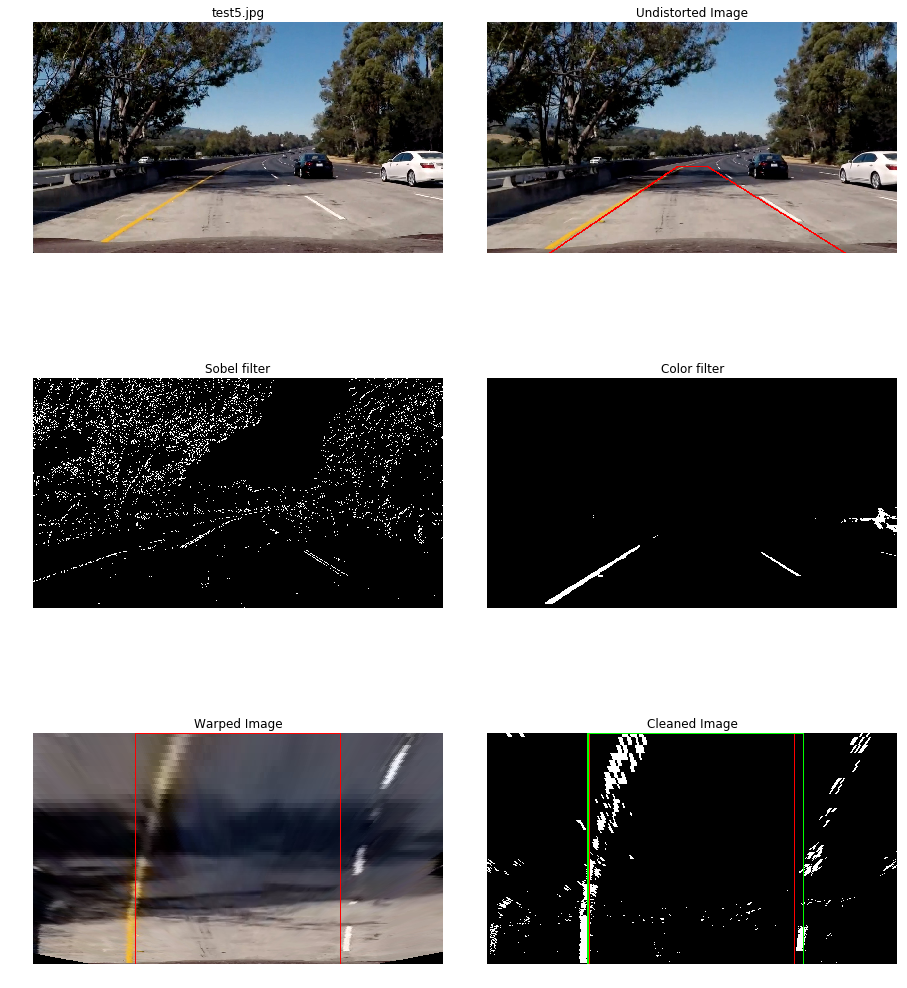

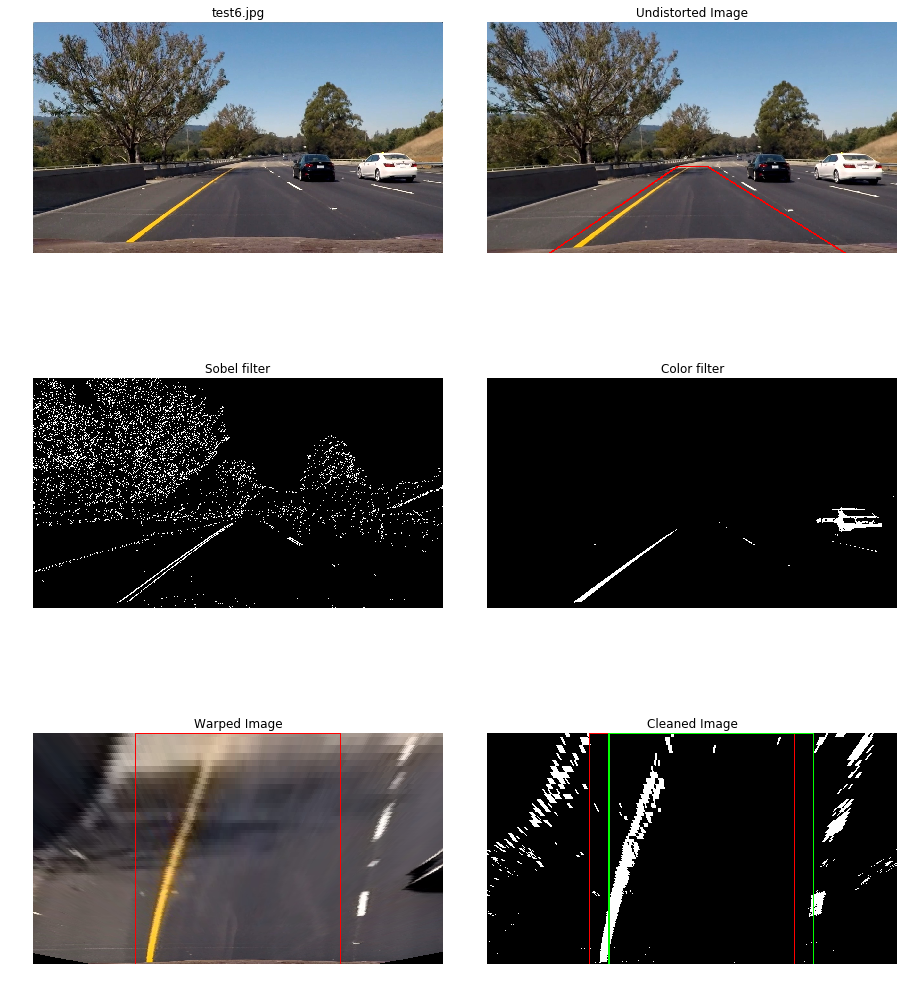

In [4]:
def undistort_image(img, mtx, dist):   
    return cv2.undistort(img, mtx, dist, None, mtx)

def sobel_threshold(img, mag_thresh, dir_thresh, x_thresh, y_thresh, kernel_size=5):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_mag = np.hypot(sobel_x, sobel_y)
    sobel_mag = np.uint8(sobel_mag * 255 / np.max(sobel_mag))
    sobel_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    binary_output = np.zeros_like(gray)    
    binary_output[((sobel_mag >= mag_thresh[0]) & (sobel_mag <= mag_thresh[1]) &
                  (sobel_dir >= dir_thresh[0]) & (sobel_dir <= dir_thresh[1])) |
                  ((sobel_x >= x_thresh[0]) & (sobel_x <= x_thresh[1]) &
                  (sobel_y >= y_thresh[0]) & (sobel_y <= y_thresh[1]))] = 1
    
    return binary_output

def color_threshold(img, h_thresh=(0,255), l_thresh=(0,255), s_thresh=(0,255)):
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls_img[:,:,0]
    l_channel = hls_img[:,:,1]
    s_channel = hls_img[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]) &
                  (l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1]) &
                  (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return binary_output

def warp_image(img, src, dst):
    M = cv2.getPerspectiveTransform(np.float32(src), dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST+cv2.WARP_FILL_OUTLIERS)
    return warped

def find_lanes(warped, window_width):
    height = warped.shape[0]
    width = warped.shape[1]    

    window = np.ones(window_width)
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[3 * height // 4:,:width // 2], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2
    
    r_sum = np.sum(warped[3 * height // 4:, width // 2:], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum)) - window_width / 2 + width // 2
    return l_center, r_center
    
ksize = 3
x_thresh = (30, 255)
y_thresh = (30, 255)
mag_thresh = (30, 255)
dir_thresh = (0.8, 1.2)
h_thresh = (0,70)
l_thresh = (120,255)
s_thresh = (120,255)

height, width, _ = IMAGE_SHAPE

apex_left = (width / 2 - 46, height / 2 + 90)
apex_right =(width / 2 + 48, height / 2 + 90)
base_left = (196, height)
base_right = (width - 162, height)

warp_xoff = 320

vertices = np.float32([[base_left, apex_left, apex_right, base_right]])
warped_vertices = np.float32([[[warp_xoff, height], [warp_xoff, 0], [width - warp_xoff, 0], [width - warp_xoff, height]]])


for filename in os.listdir(TEST_IMAGES_DIR):
    image = mpimg.imread(TEST_IMAGES_DIR + filename)

    undistorted = undistort_image(image, mtx, dist)
    
    lregion = np.copy(undistorted);
    cv2.polylines(lregion, np.int32(vertices), 0, [255,0,0], 4)

    binary_sobel = sobel_threshold(undistorted, mag_thresh, dir_thresh, x_thresh, y_thresh, kernel_size=ksize)
    binary_color = color_threshold(undistorted, h_thresh, l_thresh, s_thresh)

    warped = warp_image(undistorted, vertices, warped_vertices)
    cv2.polylines(warped, np.int32(warped_vertices), 0, [255,0,0], 4)
    
    #cleaned = np.dstack((np.zeros_like(binary_color), 255 * binary_sobel, 255 * binary_color))
    #cleaned = warp_image(cleaned, vertices, warped_vertices)
    #cv2.polylines(cleaned, np.int32(warped_vertices), 0, [255,0,0], 4)
    
    binary_lanes = binary_sobel | binary_color
    warped_lanes = warp_image(binary_lanes, vertices, warped_vertices)
    leftx, rightx = find_lanes(warped_lanes, 60)
    
    cleaned = np.zeros_like(image)
    cleaned[ warped_lanes == 1 ] = 255
    
    #cleaned = warp_image(cleaned, vertices, warped_vertices)
    cv2.polylines(cleaned, np.int32(warped_vertices), 0, [255,0,0], 4)    
    cv2.polylines(cleaned, np.int32([[[leftx, height] , [leftx, 0], [rightx, 0], [rightx, height]]]), 0, [0,255,0], 4)
    
    
    fig, ax = plt.subplots(3, 2, figsize=(12,16))
    fig.tight_layout()
    ax[0][0].imshow(image)
    ax[0][0].set_title(filename)
    ax[0][0].set_axis_off()
    ax[0][1].imshow(lregion)
    ax[0][1].set_title('Undistorted Image')
    ax[0][1].set_axis_off()
    ax[1][0].imshow(binary_sobel, cmap='gray')
    ax[1][0].set_title('Sobel filter')
    ax[1][0].set_axis_off()
    ax[1][1].imshow(binary_color, cmap='gray')
    ax[1][1].set_title('Color filter')
    ax[1][1].set_axis_off()
    ax[2][0].imshow(warped)
    ax[2][0].set_title('Warped Image')
    ax[2][0].set_axis_off()
    ax[2][1].imshow(cleaned)
    ax[2][1].set_title('Cleaned Image')
    ax[2][1].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = mpimg.imread('warped_example.jpg')
# window settings
window_width = 60 
window_height = 60 # Break image into 9 vertical layers since image height is 720
margin = 60 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()